# Load the libraries

In [1]:
# Surprise is an easy-to-use Python scikit for recommender systems. 
# Surprise has a set of built-in algorithms and datasets for you to play with. In its simplest form, it only takes a few lines of code to run a cross-validation procedure
!pip install scikit-surprise
from surprise import Reader, Dataset, SVD, KNNWithMeans, KNNBasic, KNNWithZScore
from surprise import BaselineOnly, CoClustering, SVDpp
from surprise.model_selection import cross_validate
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly.offline as plotly
import sklearn.preprocessing as prep
from sklearn.compose import ColumnTransformer
import scipy.stats as stats
import pylab 

     |████████████████████████████████| 11.8 MB 4.5 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1630167 sha256=b444dafa802cfbd8473143e95cf9bfd8c3a73ff12bb948135f64b20a74f2438c
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


# Load the dataset

In [2]:
data_col_fil = pd.read_csv("ratings.csv")
data_col_fil

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


# Checking if there are any missing values

In [3]:
data_col_fil.isnull().values.any()

False

# Summarize the data

In [4]:
# Describe the data
data_col_fil.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


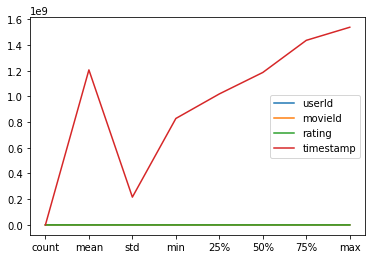

In [5]:
# Plot the data
data_col_fil.describe().plot()

# As we can see above, rating is on a scale of 5. Therefore the data is standardized, and hence it does not require any standardization. Even if we did standardize it again, the results will either be almost the same, or worse.

# However, let us prove it is standardized using a QQ plot.

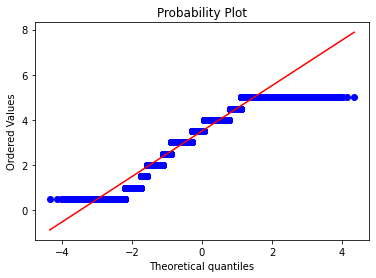

In [13]:
# QQ plot for rating
stats.probplot(data_col_fil['rating'], dist="norm", plot=pylab)
pylab.show()

# This plot shows that the data is standardized because it follows normal line.

# First, using the data as it is, ie. without manual standardization

## Convert datafactor into required data structure
The Reader class is used to parse a file containing ratings.

Such a file is assumed to specify only one rating per line, and each line needs to respect the following structure:

`user ; item ; rating ; [timestamp]`


where the order of the fields and the separator (here ‘;’) may be arbitrarily defined (see below). brackets indicate that the timestamp field is optional.

In [14]:
data = Dataset.load_from_df(data_col_fil[['userId', 'movieId', 'rating']], Reader())
data

## Compare the RMSE for different algorithms

In [15]:
comparison_table = []

# We are going to try multiple algorithms and compare their results. 
# So, we write a simple for loop that calculates the test RMSE for all algorithms
for algorithm in [SVD(n_epochs=50), KNNBasic(), KNNWithMeans(), KNNWithZScore(), 
                  BaselineOnly(), CoClustering()]:

  # Using RMSE as accuracy measure. You can also use MAE. Cross-validating with 5 folds.
  pred = cross_validate(algorithm, data, measures=['RMSE'], cv=5, verbose=False)
  print(algorithm, ': ', pred, '\n')

  # Printing the prediction directly is chaotic and unreadable.
  # Thus we combine it and compare it in a tabular form.
  results = pd.DataFrame.from_dict(pred).mean(axis=0)

  results = results.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
  comparison_table.append(results)

pd.DataFrame(comparison_table).set_index('Algorithm').sort_values('test_rmse')


<surprise.prediction_algorithms.matrix_factorization.SVD object at 0x7fde9693c250> :  {'test_rmse': array([0.88945684, 0.87830295, 0.88341295, 0.8826205 , 0.87853363]), 'fit_time': (13.056482553482056, 13.236016273498535, 13.049751043319702, 12.99780559539795, 13.841031074523926), 'test_time': (0.26453423500061035, 0.16003179550170898, 0.26354265213012695, 0.1840667724609375, 0.1705477237701416)} 

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
<surprise.prediction_algorithms.knns.KNNBasic object at 0x7fde9694a050> :  {'test_rmse': array([0.94759556, 0.94840189, 0.94359149, 0.94278418, 0.94890967]), 'fit_time': (0.1520099639892578, 0.19729304313659668, 0.19155168533325195, 

,test_rmse,fit_time,test_time
Algorithm,,,
BaselineOnly,0.872790,0.495424,0.142545
SVD,0.882465,13.236217,0.208545
KNNWithZScore,0.895604,0.303137,1.872932
KNNWithMeans,0.896715,0.305852,1.842976
CoClustering,0.941939,2.985344,0.153078
KNNBasic,0.946257,0.192706,1.637633


## From the above, we can see that baselineonly has the best RMSE, followed by SVD and then the rest. We shall train and predict the data with algorithms in the order of their best RMSEs

## Build a training set

In [16]:
trainset = data.build_full_trainset()

## Define the prediction models

In [17]:
# Tuned the hyperparameters. Default k value gives us better results. 
# SVD however has better results when epochs for it's SGD is increased from 20 to 50, since now the values always fall between 2.3 to 2.6 most times. 
# This is good since user 1's actual rating for movie 31 is 2.5. Thus, our prediction is close enough to allow some buffer while still being accurate.
svd, knnbasic, knnwithmeans, knnwithzscore, baselineonly = SVD(n_epochs=50), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly()

## Choosing user 1 for prediction and displaying all their movies and ratings

In [18]:
data_col_fil[data_col_fil['userId'] == 1]

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
227,1,3744,4.0,964980694
228,1,3793,5.0,964981855
229,1,3809,4.0,964981220
230,1,4006,4.0,964982903


## Baseline Only

In [19]:
baselineonly.fit(trainset)

# Giving userId as 1 and movieId as 31
pred_baselineonly = baselineonly.predict(1, 31)
pred_baselineonly

Estimating biases using als...


Prediction(uid=1, iid=31, r_ui=None, est=4.024399831290997, details={'was_impossible': False})

## Simple Value Decomposition

In [20]:
svd.fit(trainset)

# Giving userId as 1 and movieId as 31
pred_svd = svd.predict(1, 31)
pred_svd

Prediction(uid=1, iid=31, r_ui=None, est=3.74400781314095, details={'was_impossible': False})

## KNN with Z-Score

In [21]:
knnwithzscore.fit(trainset)

# Giving userId as 1 and movieId as 31
pred_knnwithzscore = knnwithzscore.predict(1, 31)
pred_knnwithzscore

Computing the msd similarity matrix...
Done computing similarity matrix.


Prediction(uid=1, iid=31, r_ui=None, est=4.136348983548089, details={'actual_k': 38, 'was_impossible': False})

## KNN with Means

In [22]:
knnwithmeans.fit(trainset)

# Giving userId as 1 and movieId as 31
pred_knnwithmeans = knnwithmeans.predict(1, 31)
pred_knnwithmeans

Computing the msd similarity matrix...
Done computing similarity matrix.


Prediction(uid=1, iid=31, r_ui=None, est=4.099991382604308, details={'actual_k': 38, 'was_impossible': False})

## Co-clustering

In [23]:
# coclustering.fit(trainset)

# # Giving userId as 1 and movieId as 31
# pred_coclustering = coclustering.predict(1, 31)
# pred_coclustering

## Basic KNN

In [24]:
knnbasic.fit(trainset)

# Giving userId as 1 and movieId as 31
pred_knnbasic = knnbasic.predict(1, 31)
pred_knnbasic

Computing the msd similarity matrix...
Done computing similarity matrix.


Prediction(uid=1, iid=31, r_ui=None, est=3.295949570922538, details={'actual_k': 38, 'was_impossible': False})